In [1]:
import numpy as np
import pandas as pd
import missingno as msno #use to plot missing data
import seaborn as sns
import matplotlib.pyplot as plt

import ast
import wfdb #use to read the ecg database
import random

In [2]:
#Create a python function to load ecg metadata.
file_path = r'12Lead_ECG_Data/PTBXL_DataSet/'

def loadmeta_df (file_name, index = 'ecg_id'):
    df = pd.read_csv(file_path + file_name, index_col= index)
    return df

In [3]:
#Load ECG data.  The ptxl_database.csv contains the metadata of all ECG records
df_ECG_data = loadmeta_df(r'ptbxl_database.csv')
df_ECG_data.head()

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr


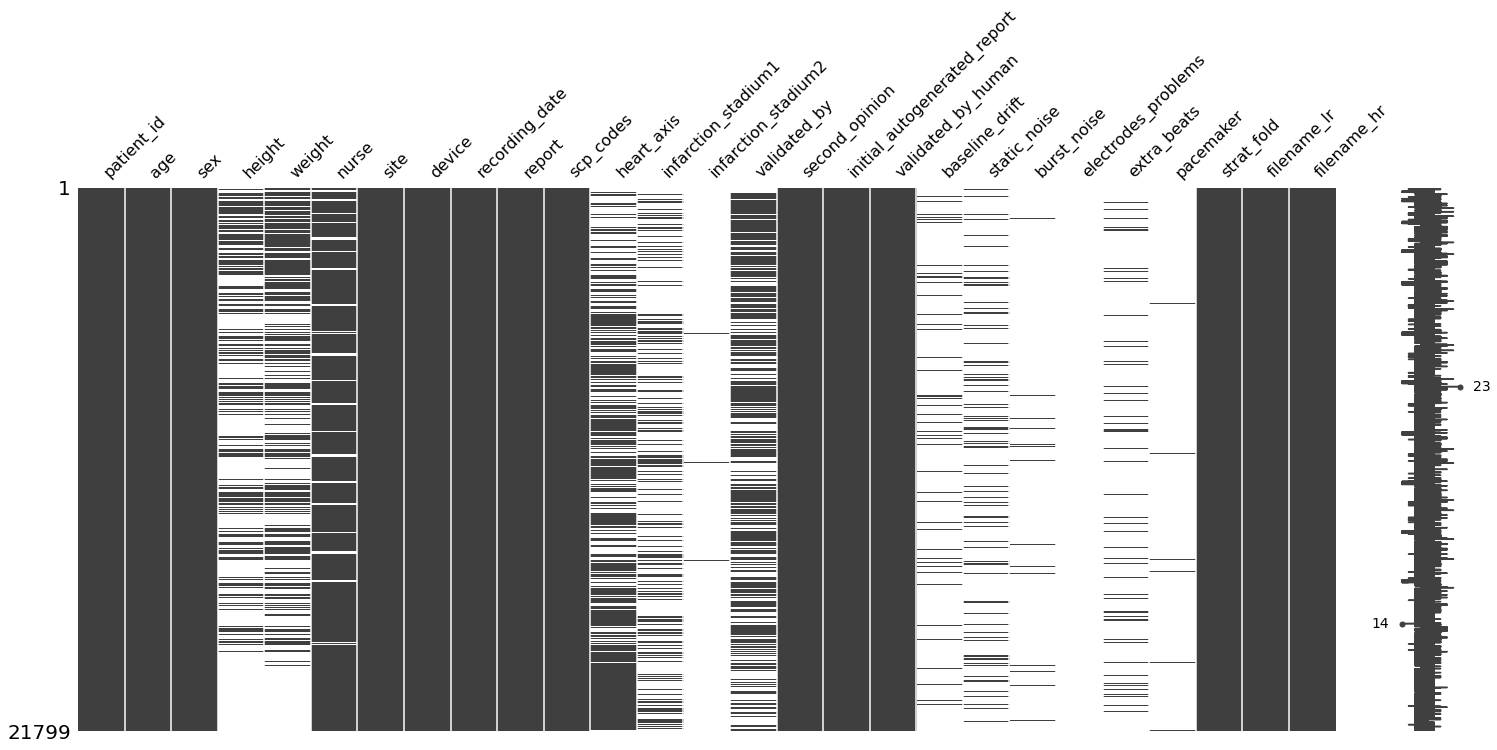

In [4]:
#Display missing values 
_= msno.matrix(df_ECG_data)

#Black pixels indicates existing values and missing values remain white.

In [5]:
df_ECG_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21799 entries, 1 to 21837
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   patient_id                    21799 non-null  float64
 1   age                           21799 non-null  float64
 2   sex                           21799 non-null  int64  
 3   height                        6974 non-null   float64
 4   weight                        9421 non-null   float64
 5   nurse                         20326 non-null  float64
 6   site                          21782 non-null  float64
 7   device                        21799 non-null  object 
 8   recording_date                21799 non-null  object 
 9   report                        21799 non-null  object 
 10  scp_codes                     21799 non-null  object 
 11  heart_axis                    13331 non-null  object 
 12  infarction_stadium1           5612 non-null   object 
 13  i

In [6]:
#drop some of the data due to severely missing data or relevancy
columns= df_ECG_data.columns
drop_columns_MissingData = columns[[12, 13, 18, 19, 20, 22, 23]] #severely missing data columns. Keep the electrode problem columne as it may be necessary to drop readings related to electrod problems.
drop_columns_recomended = columns[[5, 6, 7, 9]] #recommended columns to drop

drop_columns = list(drop_columns_MissingData) + list(drop_columns_recomended)

df_ECG_data_clean = df_ECG_data.drop(columns= drop_columns)

In [7]:
df_ECG_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21799 entries, 1 to 21837
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   patient_id                    21799 non-null  float64
 1   age                           21799 non-null  float64
 2   sex                           21799 non-null  int64  
 3   height                        6974 non-null   float64
 4   weight                        9421 non-null   float64
 5   recording_date                21799 non-null  object 
 6   scp_codes                     21799 non-null  object 
 7   heart_axis                    13331 non-null  object 
 8   validated_by                  12421 non-null  float64
 9   second_opinion                21799 non-null  bool   
 10  initial_autogenerated_report  21799 non-null  bool   
 11  validated_by_human            21799 non-null  bool   
 12  electrodes_problems           30 non-null     object 
 13  s

In [8]:
#Update the electrode problem feature to Yes or NO 
df_ECG_data_clean.electrodes_problems = df_ECG_data_clean.electrodes_problems.where(df_ECG_data_clean.electrodes_problems.isna(), other= 'yes')
df_ECG_data_clean.electrodes_problems = df_ECG_data_clean.electrodes_problems.fillna('no')

In [9]:
df_ECG_data_clean.describe()

,patient_id,age,sex,height,weight,validated_by,strat_fold
count,21799.000000,21799.000000,21799.000000,6974.000000,9421.000000,12421.000000,21799.000000
mean,11250.156521,62.769301,0.479150,166.702323,70.995223,0.746075,5.503005
std,6235.026404,32.308813,0.499577,10.867321,15.878803,1.178003,2.874948
min,302.000000,2.000000,0.000000,6.000000,5.000000,0.000000,1.000000
25%,5974.500000,50.000000,0.000000,160.000000,60.000000,0.000000,3.000000
50%,11419.000000,62.000000,0.000000,166.000000,70.000000,1.000000,6.000000
75%,16607.500000,72.000000,1.000000,174.000000,80.000000,1.000000,8.000000
max,21797.000000,300.000000,1.000000,209.000000,250.000000,11.000000,10.000000


Plot a summary of age, height and weight. Use histogram and boxplot to get a sense of the distribution and determine how to fill na values

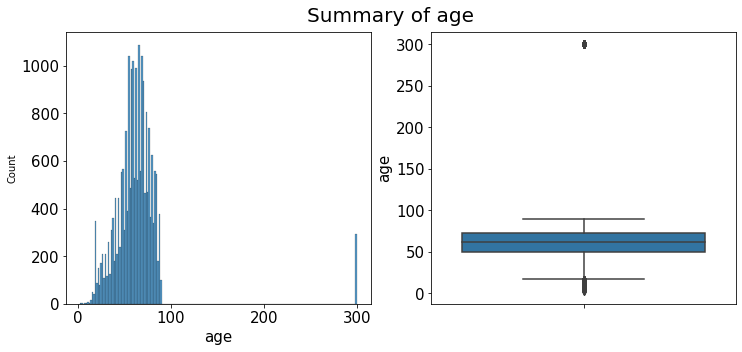

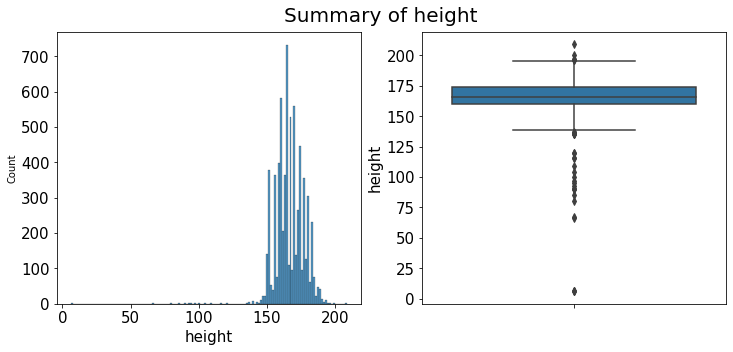

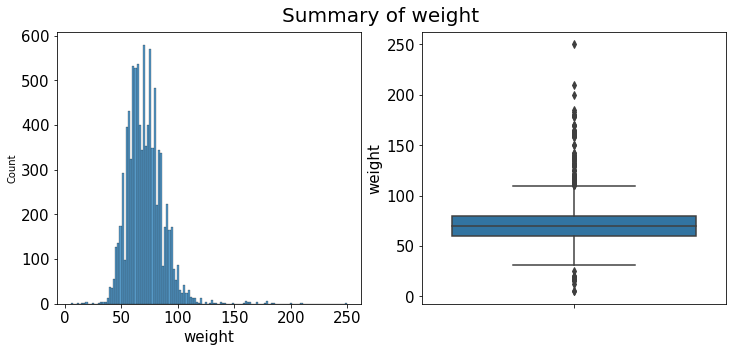

In [10]:
features= ['age', 'height', 'weight']
label_size= 15

for feature in features:

    fig, (ax1, ax2) = plt.subplots(figsize= (12, 5), ncols= 2, nrows= 1)
    _= sns.histplot(x= feature, ax= ax1, data= df_ECG_data_clean)
    _= sns.boxplot(y= feature, data= df_ECG_data_clean, ax= ax2)

    ax1.set_xlabel(feature, fontsize = label_size)
    ax1.tick_params(axis= 'both', labelsize= label_size)


    ax2.set_ylabel(feature, fontsize = label_size)
    ax2.tick_params(axis= 'both', labelsize= label_size)

    _=fig.suptitle(f'Summary of {feature}', fontsize= 20, y= 0.95)

The plots shows a few outliesrs but there is some symmetry around the mean for the height and weight. 
For this reasons replace nan with median for age, height and weight (Using the median instead of the mean the avoid biasing the result).
The age column have values 300s (This suggest an errouneous recording) 

In [11]:
df_ECG_data_clean[['age','height', 'weight']] = df_ECG_data_clean[['age','height', 'weight']].fillna(df_ECG_data_clean[['age','height', 'weight']].median())


In [12]:
df_ECG_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21799 entries, 1 to 21837
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   patient_id                    21799 non-null  float64
 1   age                           21799 non-null  float64
 2   sex                           21799 non-null  int64  
 3   height                        21799 non-null  float64
 4   weight                        21799 non-null  float64
 5   recording_date                21799 non-null  object 
 6   scp_codes                     21799 non-null  object 
 7   heart_axis                    13331 non-null  object 
 8   validated_by                  12421 non-null  float64
 9   second_opinion                21799 non-null  bool   
 10  initial_autogenerated_report  21799 non-null  bool   
 11  validated_by_human            21799 non-null  bool   
 12  electrodes_problems           21799 non-null  object 
 13  s

Bin age, height and weight in groups/category: Grouping is done by trying different bins and ploting the data. The goal was to a general uniform bins

In [13]:
df_ECG_data_clean['Age_Group'] = pd.cut(df_ECG_data_clean.age, bins= [0, 55, 70, 100]).astype('str')
df_ECG_data_clean['Height_Group'] = pd.cut(df_ECG_data_clean.height, bins= [90, 166, 167, 200]).astype('str')
df_ECG_data_clean['Weight_Group'] = pd.cut(df_ECG_data_clean.weight, bins= [0, 40, 50, 60, 70, 80, 210]).astype('str')

Now load the ecp statement and determine the corresponding heart rhyth based on scp codes from the ECG data

In [14]:
df_ECG_data_clean.scp_codes = df_ECG_data_clean.scp_codes.apply(lambda x: ast.literal_eval(x)) #convert scp codes to dictionary type
df_scp = loadmeta_df (r'scp_statements.csv', index= 0)
df_scp.head()

,description,diagnostic,form,rhythm,diagnostic_class,diagnostic_subclass,Statement Category,SCP-ECG Statement Description,AHA code,aECG REFID,CDISC Code,DICOM Code
NDT,non-diagnostic T abnormalities,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,non-diagnostic T abnormalities,NaN,NaN,NaN,NaN
NST_,non-specific ST changes,1.0,1.0,NaN,STTC,NST_,Basic roots for coding ST-T changes and abnorm...,non-specific ST changes,145.0,MDC_ECG_RHY_STHILOST,NaN,NaN
DIG,digitalis-effect,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,suggests digitalis-effect,205.0,NaN,NaN,NaN
LNGQT,long QT-interval,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,long QT-interval,148.0,NaN,NaN,NaN
NORM,normal ECG,1.0,NaN,NaN,NORM,NORM,Normal/abnormal,normal ECG,1.0,NaN,NaN,F-000B7


In [15]:
#Get only the scp data frame that is related to hear rhytm (hr)
df_scp_hr = df_scp[df_scp.rhythm == 1.0]
df_scp_hr.head()

,description,diagnostic,form,rhythm,diagnostic_class,diagnostic_subclass,Statement Category,SCP-ECG Statement Description,AHA code,aECG REFID,CDISC Code,DICOM Code
SR,sinus rhythm,NaN,NaN,1.0,NaN,NaN,Statements related to impulse formation (abnor...,sinus rhythm,20.0,MDC_ECG_RHY_SINUS_RHY,NaN,NaN
AFIB,atrial fibrillation,NaN,NaN,1.0,NaN,NaN,Statements related to impulse formation (abnor...,atrial fibrillation,50.0,MDC_ECG_RHY_ATR_FIB,NaN,D3-31520
STACH,sinus tachycardia,NaN,NaN,1.0,NaN,NaN,Statements related to impulse formation (abnor...,sinus tachycardia,21.0,MDC_ECG_RHY_SINUS_TACHY,NaN,NaN
SARRH,sinus arrhythmia,NaN,NaN,1.0,NaN,NaN,Statements related to impulse formation (abnor...,sinus arrhythmia,23.0,MDC_ECG_RHY_SINUS_ARRHY,NaN,NaN
SBRAD,sinus bradycardia,NaN,NaN,1.0,NaN,NaN,Statements related to impulse formation (abnor...,sinus bradycardia,22.0,MDC_ECG_RHY_SINUS_BRADY,NaN,NaN


In [16]:
#write a function that takes in the scp_code and returns the Hr diagnosis
heart_rhythm = df_scp_hr.index
def hr_diagnosis (scp_code):
    for r in scp_code.keys():
        if r in heart_rhythm:
            return r
        

print (heart_rhythm)

Index(['SR', 'AFIB', 'STACH', 'SARRH', 'SBRAD', 'PACE', 'SVARR', 'BIGU',
       'AFLT', 'SVTAC', 'PSVT', 'TRIGU'],
      dtype='object')


In [17]:
df_ECG_data_clean['heart_rhythm'] = df_ECG_data_clean.scp_codes.apply(hr_diagnosis)

<AxesSubplot:>

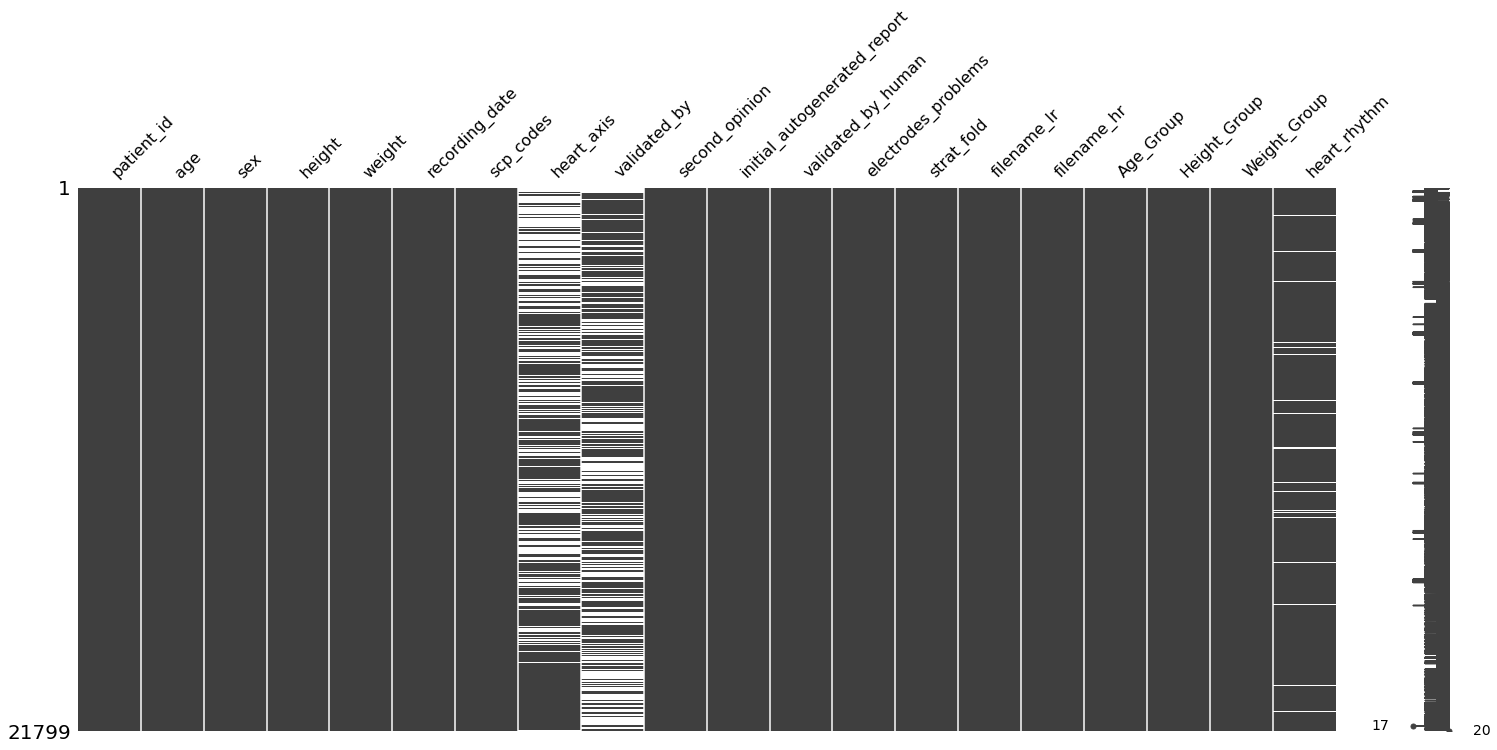

In [18]:
msno.matrix(df_ECG_data_clean)

In [19]:
df_ECG_data_clean.head()

,patient_id,age,sex,height,weight,recording_date,scp_codes,heart_axis,validated_by,second_opinion,initial_autogenerated_report,validated_by_human,electrodes_problems,strat_fold,filename_lr,filename_hr,Age_Group,Height_Group,Weight_Group,heart_rhythm
ecg_id,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,166.0,63.0,1984-11-09 09:17:34,"{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}",NaN,NaN,False,False,True,no,3,records100/00000/00001_lr,records500/00000/00001_hr,"(55, 70]","(90, 166]","(60, 70]",SR
2,13243.0,19.0,0,166.0,70.0,1984-11-14 12:55:37,"{'NORM': 80.0, 'SBRAD': 0.0}",NaN,NaN,False,False,True,no,2,records100/00000/00002_lr,records500/00000/00002_hr,"(0, 55]","(90, 166]","(60, 70]",SBRAD
3,20372.0,37.0,1,166.0,69.0,1984-11-15 12:49:10,"{'NORM': 100.0, 'SR': 0.0}",NaN,NaN,False,False,True,no,5,records100/00000/00003_lr,records500/00000/00003_hr,"(0, 55]","(90, 166]","(60, 70]",SR
4,17014.0,24.0,0,166.0,82.0,1984-11-15 13:44:57,"{'NORM': 100.0, 'SR': 0.0}",NaN,NaN,False,False,True,no,3,records100/00000/00004_lr,records500/00000/00004_hr,"(0, 55]","(90, 166]","(80, 210]",SR
5,17448.0,19.0,1,166.0,70.0,1984-11-17 10:43:15,"{'NORM': 100.0, 'SR': 0.0}",NaN,NaN,False,False,True,no,4,records100/00000/00005_lr,records500/00000/00005_hr,"(0, 55]","(90, 166]","(60, 70]",SR


In [20]:
df_ECG_data_clean.dropna(axis= 0, subset= ['heart_rhythm'], inplace= True)

In [21]:
df_ECG_data_clean.heart_rhythm.unique()

array(['SR', 'SBRAD', 'SARRH', 'AFLT', 'STACH', 'PACE', 'AFIB', 'SVTAC',
       'PSVT', 'BIGU', 'TRIGU', 'SVARR'], dtype=object)

In [22]:
#Remove PACE (Pace maker), BIGU and TRIGU (both unknown origin)
df_ECG_data_clean = df_ECG_data_clean[(df_ECG_data_clean.heart_rhythm != 'PACE') & (df_ECG_data_clean.heart_rhythm != 'BIGU') & (df_ECG_data_clean.heart_rhythm != 'TRIGU')].copy()


In [23]:
df_ECG_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20699 entries, 1 to 21837
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   patient_id                    20699 non-null  float64
 1   age                           20699 non-null  float64
 2   sex                           20699 non-null  int64  
 3   height                        20699 non-null  float64
 4   weight                        20699 non-null  float64
 5   recording_date                20699 non-null  object 
 6   scp_codes                     20699 non-null  object 
 7   heart_axis                    13035 non-null  object 
 8   validated_by                  11784 non-null  float64
 9   second_opinion                20699 non-null  bool   
 10  initial_autogenerated_report  20699 non-null  bool   
 11  validated_by_human            20699 non-null  bool   
 12  electrodes_problems           20699 non-null  object 
 13  s

In [24]:
#Save the cleaned ECG data frame for future use.
df_ECG_data_clean.to_csv('ptbxl_database_cleaned.csv')

## Now Work on loading ECG files

In [25]:
def load_raw_data (df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp (path + f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp (path + f) for f in df.filename_hr]
    
    data = np.array([signal for signal, meta in data])
    return data

In [26]:
df_ECG_signal = load_raw_data(df= df_ECG_data_clean, sampling_rate= 100, path= file_path)
df_ECG_signal.shape

(20699, 1000, 12)

In [27]:
df_ECG_data_clean.reset_index(inplace= True)

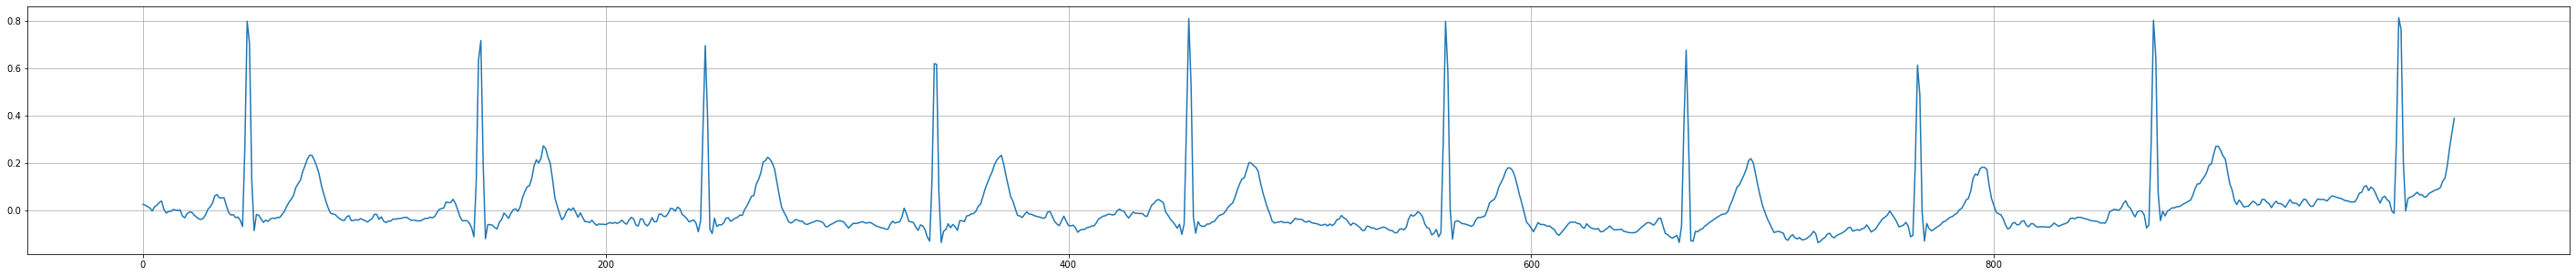

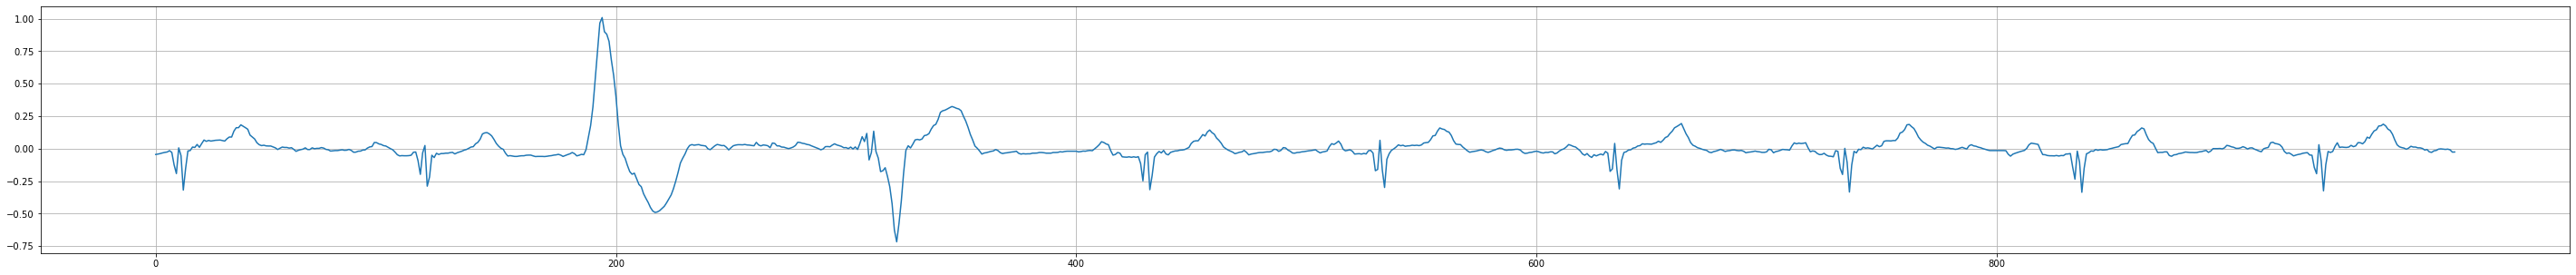

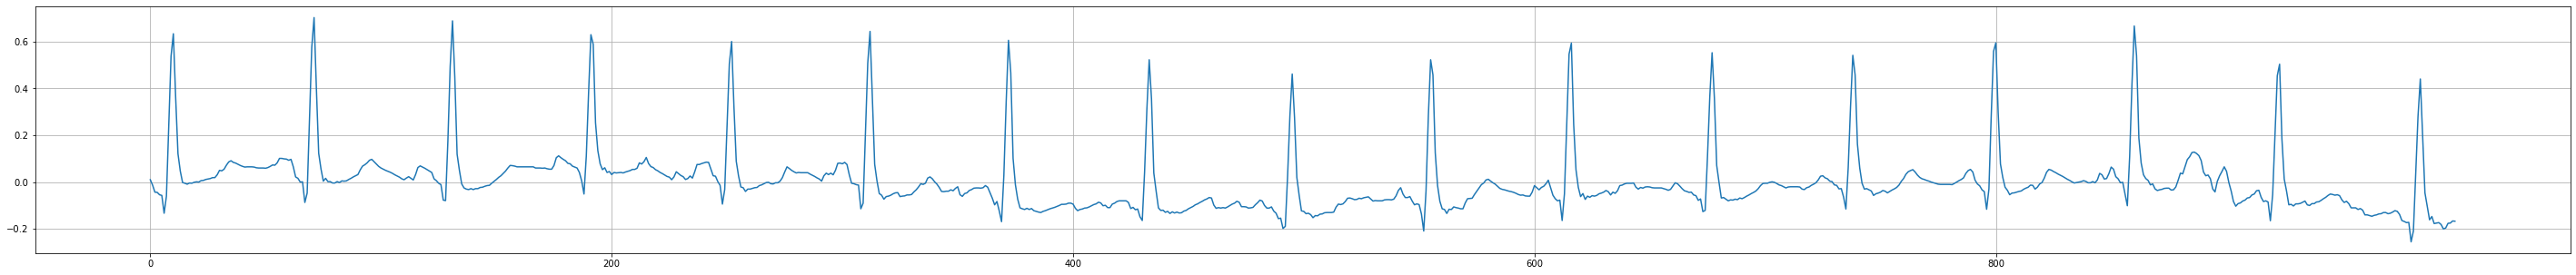

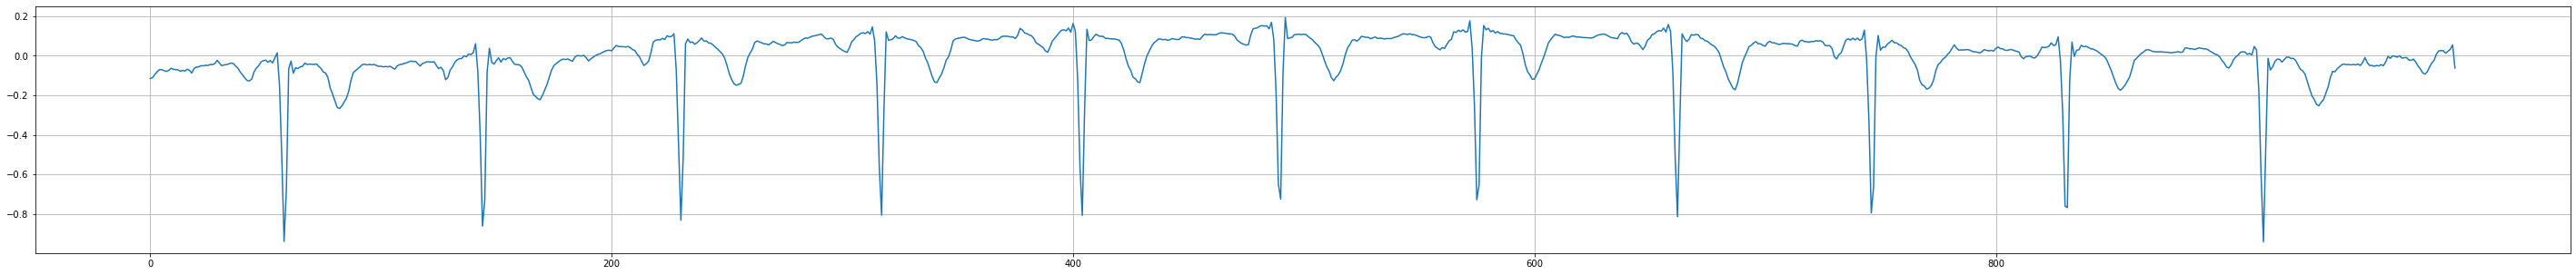

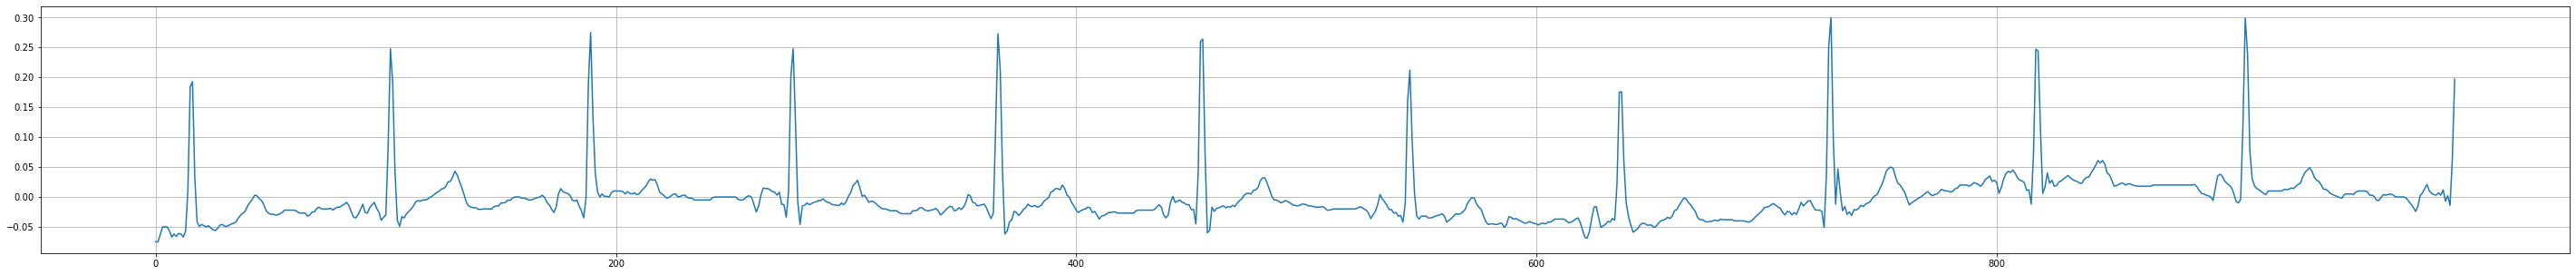

In [28]:
#Select five random patients with normal arrythmia and plot ECG signals from the first five leads
normal_patient_index= random.sample(list(df_ECG_data_clean[df_ECG_data_clean.heart_rhythm == 'SR'].index), 5)
for i, patient in enumerate(normal_patient_index):
    plt.figure(figsize= (50, 5))
    plt.plot(df_ECG_signal[patient, :, i])
    plt.xticks(np.arange(0, 1000, 200))
    plt.grid(True)

In [29]:
df_ECG_data_clean.heart_rhythm.unique()

array(['SR', 'SBRAD', 'SARRH', 'AFLT', 'STACH', 'AFIB', 'SVTAC', 'PSVT',
       'SVARR'], dtype=object)

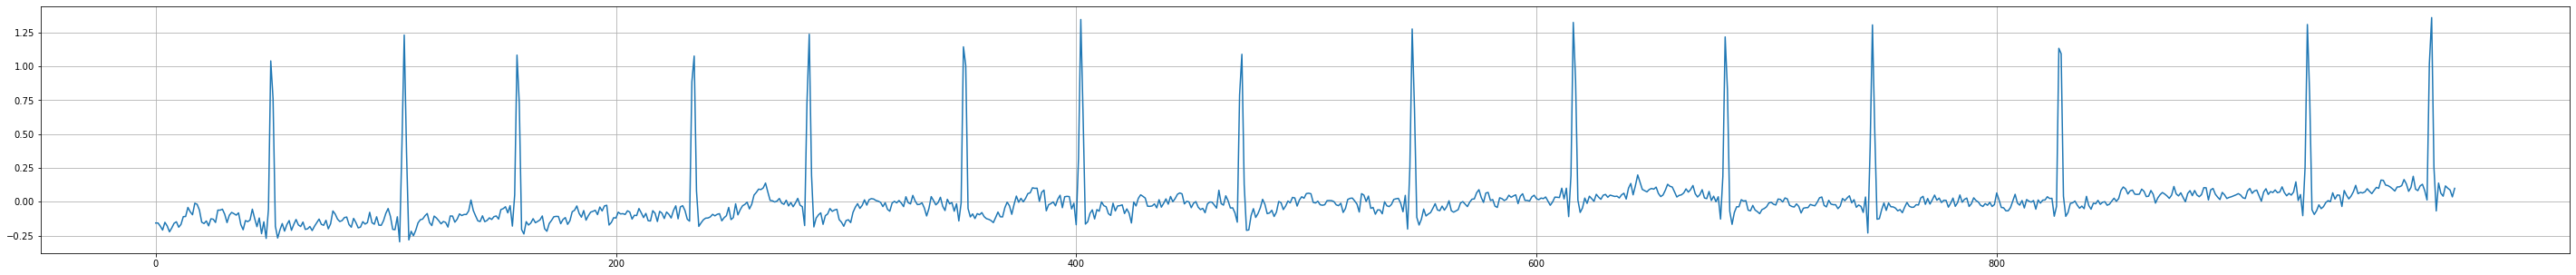

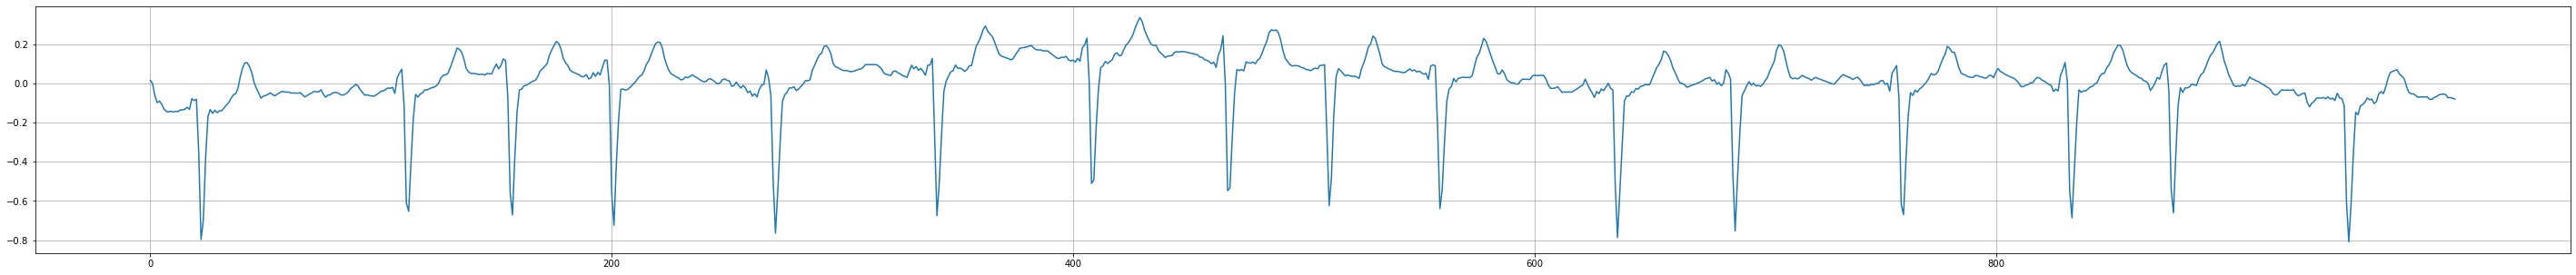

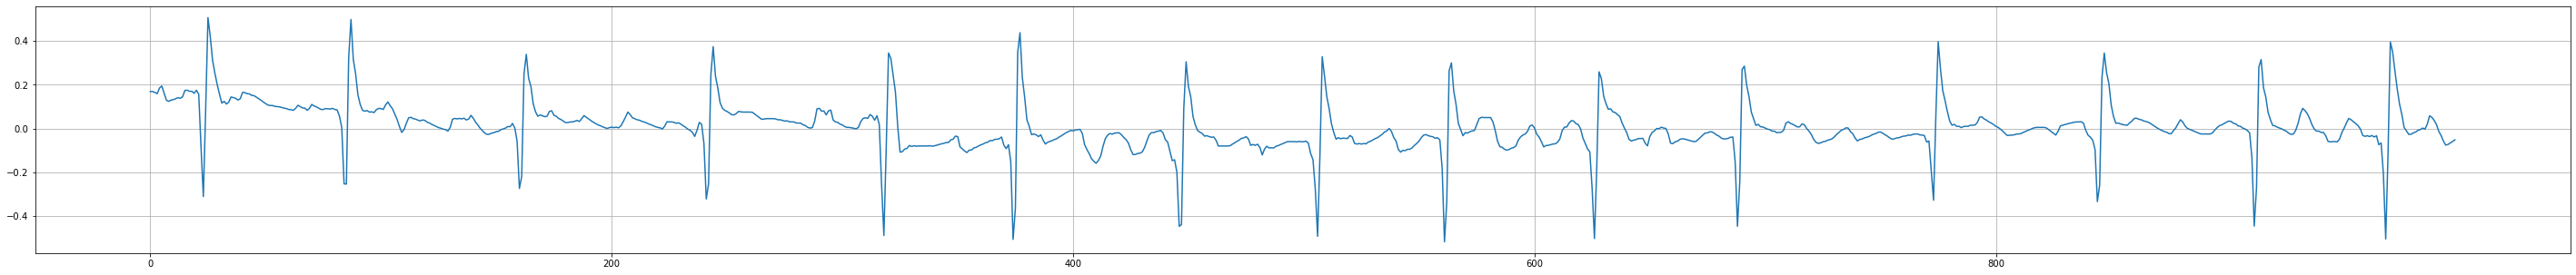

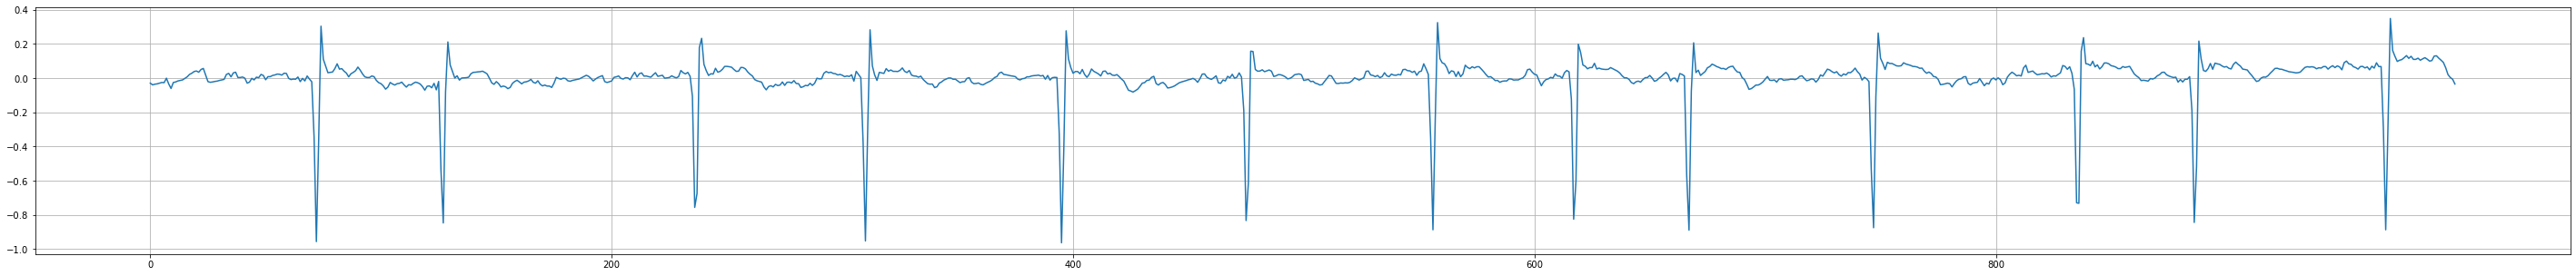

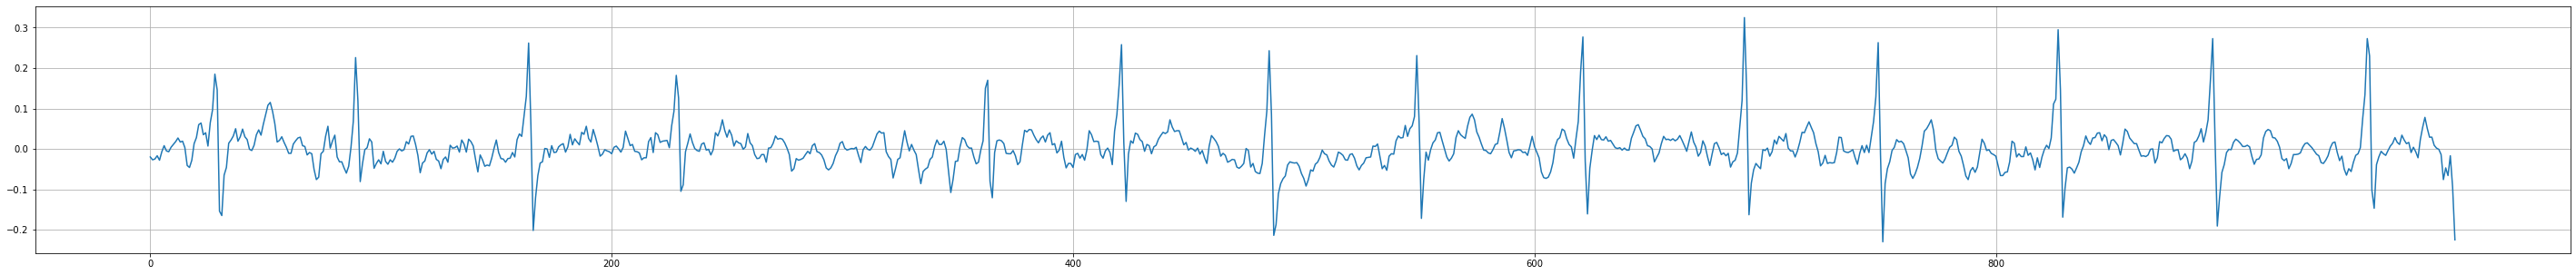

In [30]:
normal_patient_index= random.sample(list(df_ECG_data_clean[df_ECG_data_clean.heart_rhythm == 'AFIB'].index), 5)
for i, patient in enumerate(normal_patient_index):
    plt.figure(figsize= (50, 5))
    plt.plot(df_ECG_signal[patient, :, i])
    plt.xticks(np.arange(0, 1000, 200))
    plt.grid(True)

In [31]:
#save numpy array for future use
np.save ('ECG_signal.npy', df_ECG_signal)